In [34]:
import pymysql

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%jupyter 

In [183]:
conn = pymysql.connect(host = 'codeborn-bi-db.cvv1o1yrngie.ap-northeast-2.rds.amazonaws.com',
                        port = 3306,
                        user = 'butterfree',
                        password = '4hHl68aS8UbJ',
                        db = 'codeborn')

sql_courses = "SELECT course_id FROM courses\
                WHERE professor_id = 11"
courses_data = pd.read_sql_query(sql_courses, conn)

sql_assignments = "SELECT * FROM assignments"
assignments_data = pd.read_sql_query(sql_assignments, conn)

sql_submissions = "SELECT submission_id, assignment_id, student_id, submit_date, total_score\
                    FROM submissions\
                    WHERE assignment_id != 1\
                        AND student_id != 11"
submissions_data = pd.read_sql_query(sql_submissions, conn)

sql_students = "SELECT * FROM students"
students_data = pd.read_sql_query(sql_students, conn)

In [11]:
assignment_columns = ["course_id",  "assignment_id", "started_date", "ended_date"]
assignment_id = assignments_data[assignment_columns]

In [13]:
# 1번 각 코스별로 제출 학생의 숫자와 숙제 평균 맞는 개수를 출력하시오
assignment_id = assignment_id[assignment_id["assignment_id"] != 1]

In [15]:
courses_assignment= pd.merge(courses_data, assignment_id, on='course_id', how='left')

In [17]:
# 변수명이 두루뭉실함 조금 더 변수가 뭘 담고있는지 확실하게 적어주면 코드나 나중에 길어질 떄 이름만 보고 판별이 가능함
join_data = pd.merge(courses_assignment, submissions_data, on='assignment_id', how= 'left') 

In [29]:
join_data_count =  join_data.groupby('course_id').agg({'assignment_id': 'nunique',
                                    'submission_id': 'count'})

In [28]:
# join_data_count.columns = ["assignment_count",
#                            "submission_count"]

In [30]:
join_data_count.rename(
    columns = {'assignment_id':'assignment_count', 'submission_id':'submission_count'}, inplace=True)
join_data_count

,assignment_count,submission_count
course_id,,
DSAA-2021,11,3568
DSAA-2022,7,3379
PY-2022S,11,14110


In [33]:
# join_data_count.reset_index(drop=True)
# 인덱스 없에고 reset_index 하는 방법

,assignment_count,submission_count
0,11,3568
1,7,3379
2,11,14110


In [35]:
join_data_count = join_data_count.reset_index()
join_data_count

,course_id,assignment_count,submission_count
0,DSAA-2021,11,3568
1,DSAA-2022,7,3379
2,PY-2022S,11,14110


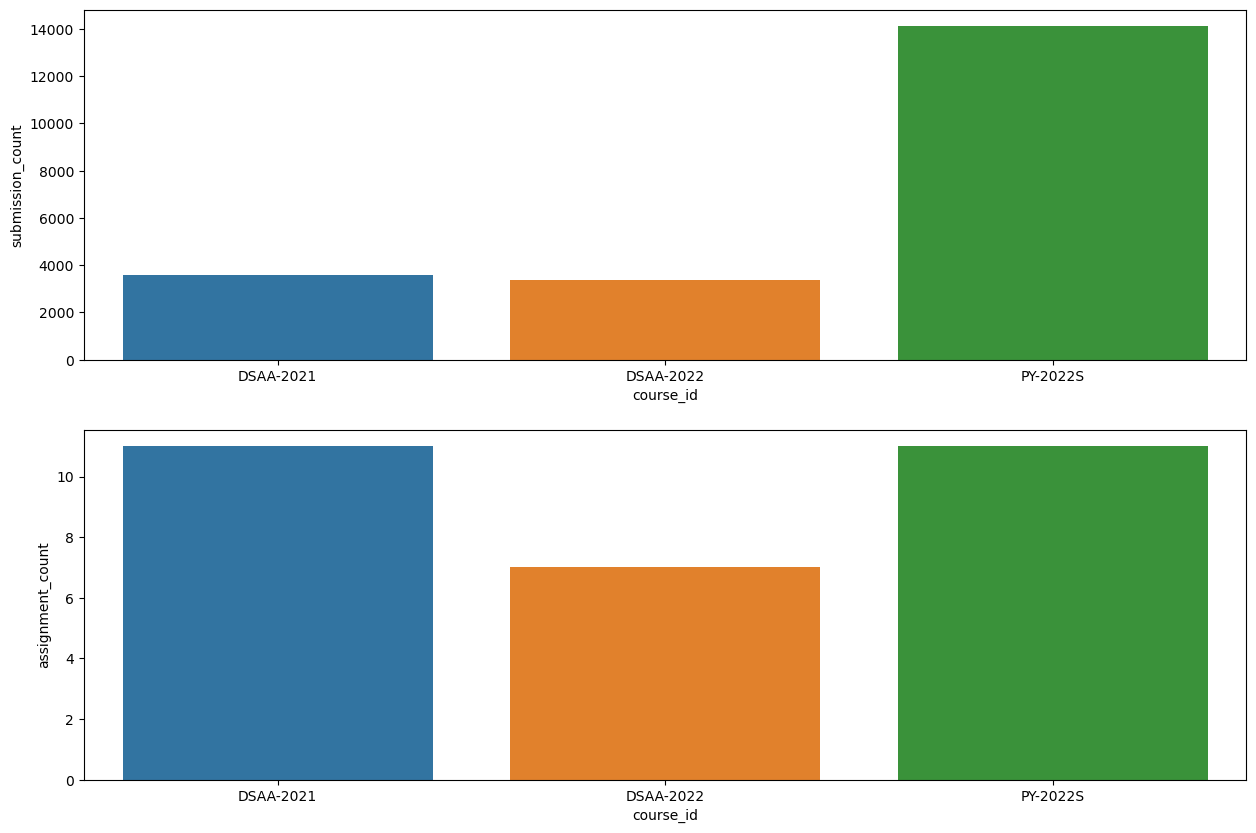

In [38]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
sns.barplot(x = "course_id", y = "submission_count", data = join_data_count, ax = ax[0]);
sns.barplot(x = "course_id", y = "assignment_count", data = join_data_count, ax = ax[1]);

In [82]:
# 2번 각 코스별, 숙제별로 숙제를 가장 빨리 제출한 학생의 아이디와 제출한 시간을 출력하시오
sql_submissions = "SELECT submission_id, assignment_id, student_id, submit_date FROM submissions\
                    WHERE assignment_id != 1\
                        AND student_id != 11"
submission_df = pd.read_sql_query(sql_submissions, conn)

In [83]:
submitdate_df = pd.merge(courses_assignment, submission_df, on='assignment_id', how= 'left') 

In [84]:
submit_condition_1 = submitdate_df.started_date <= submitdate_df.submit_date
submit_condition_2 = submitdate_df.ended_date >= submitdate_df.submit_date

In [85]:
submitdate_df = submitdate_df[submit_condition_1 & submit_condition_2]

In [90]:
# idxmin만 추출하고 reset_index 후 merge 시킬 수 있을 것 같음
# submitdate_df.groupby(['course_id','assignment_id']).agg({"submit_date": "idxmin"}).reset_index()

In [91]:
submitdate_df

,course_id,assignment_id,started_date,ended_date,submission_id,student_id,submit_date
43,DSAA-2021,2,2021-09-19,2021-09-25,72,16,2021-09-20 00:53:24
44,DSAA-2021,2,2021-09-19,2021-09-25,73,16,2021-09-20 00:54:13
45,DSAA-2021,2,2021-09-19,2021-09-25,74,16,2021-09-20 00:55:32
46,DSAA-2021,2,2021-09-19,2021-09-25,75,29,2021-09-20 01:00:57
47,DSAA-2021,2,2021-09-19,2021-09-25,76,29,2021-09-20 01:01:37
...,...,...,...,...,...,...,...
20490,PY-2022S,34,2022-05-29,2022-06-13,17416,132,2022-06-12 23:04:22
20491,PY-2022S,34,2022-05-29,2022-06-13,17417,132,2022-06-12 23:06:26
20492,PY-2022S,34,2022-05-29,2022-06-13,17418,132,2022-06-12 23:07:08
20493,PY-2022S,34,2022-05-29,2022-06-13,17419,132,2022-06-12 23:14:07


In [97]:
# submitdate_df.loc[
#     submitdate_df.groupby(['course_id','assignment_id'])['submit_date'].idxmin()
#     ][["course_id", "assignment_id", "submit_date", "student_id"]]

In [98]:
min_submit_date = submitdate_df.groupby(['course_id','assignment_id'])['submit_date'].min()

student_id_with_min_submit_date = submitdate_df.loc[
    submitdate_df.groupby(['course_id','assignment_id'])['submit_date'].idxmin()
    ][["course_id", "assignment_id", "submit_date", "student_id"]]

In [67]:
# result = pd.concat([min_submit_date.reset_index(), student_id_with_min_submit_date], axis=1)
# result[student_id_with_min_submit_date.columns].equals(student_id_with_min_submit_date.reset_index(drop=True))

,course_id,assignment_id,submit_date,index,student_id
0,DSAA-2021,2,2021-09-20 00:53:24,43,16
1,DSAA-2021,3,2021-09-18 14:30:01,983,15
2,DSAA-2021,6,2021-09-23 10:35:09,1027,28
3,DSAA-2021,8,2021-09-23 16:06:08,1250,12
4,DSAA-2021,10,2021-09-26 21:35:40,1411,24
5,DSAA-2021,11,2021-09-27 03:01:48,1427,21
6,DSAA-2021,13,2021-09-28 10:22:41,1506,52
7,DSAA-2021,14,2021-10-07 10:06:31,2300,42
8,DSAA-2021,16,2021-10-31 19:17:00,3213,25
9,DSAA-2021,18,2021-11-16 10:15:11,3446,30


In [112]:
# 3번 각 코스별, 숙제별로 학생들이 숙제를 제출한 횟수를 출력하시오
submission_id_df = pd.merge(courses_assignment, submission_df, on='assignment_id', how='left') 
submission_id_df = submission_id_df[submission_id_df.started_date <= submission_id_df.submit_date]
submission_id_df = submission_id_df[submission_id_df.ended_date >= submission_id_df.submit_date]

In [173]:
# submission_id_df.groupby(['course_id','assignment_id'], as_index=False)["submission_id"].count()

In [113]:
submit_count_df = submission_id_df.groupby(['course_id','assignment_id']).agg({
                            'submission_id': 'count'
                        })

# submit_count_df = submission_id_df.groupby(['course_id','assignment_id'], as_index=False)["submission_id"].count()
submit_count_df

submission_id
course_id assignment_id               
DSAA-2021 2                        155
          3                         40
          6                        180
          8                        109
          10                        14
          11                        26
          13                       728
          14                       790
          16                       228
          18                       116
          22                         2
DSAA-2022 35                       392
          36                       119
          37                        90
          38                       265
          39                        84
          40                       538
          41                        67
PY-2022S  21                         7
          23                       735
          24                      1332
          25                      1326
          26                       775
          27                       435
          28                        10
          29                      1897
          30                      2074
          33                       677
          34                       804

In [116]:
submit_count_df = submit_count_df.reset_index()

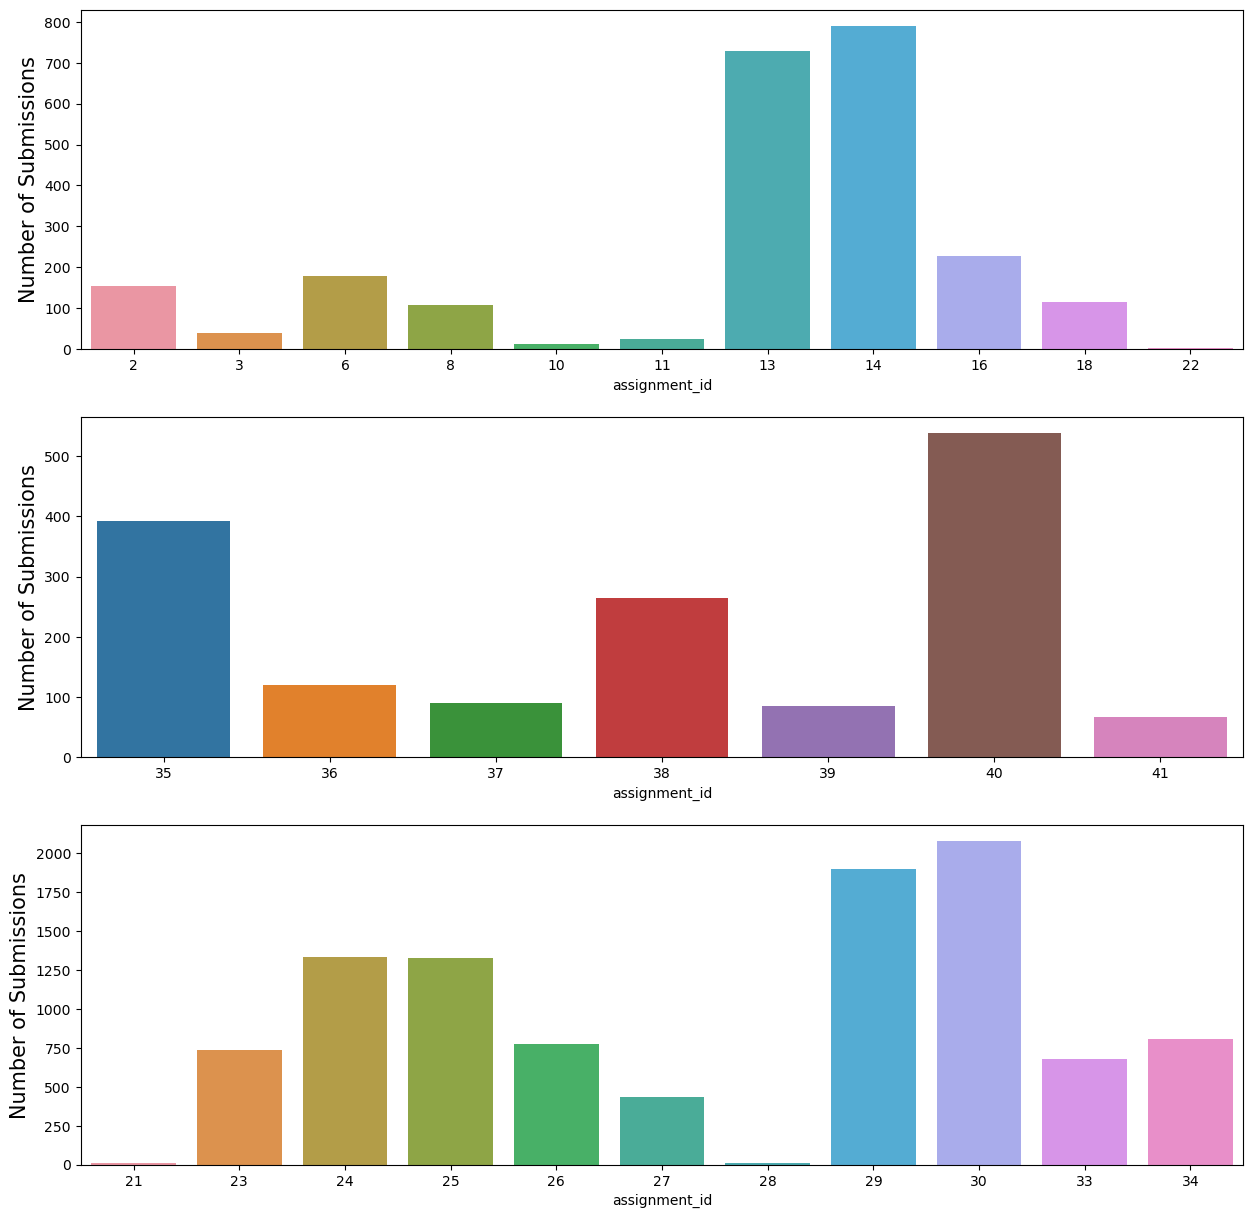

In [134]:
def my_barplot(x_name, y_name, dataframe, axes_number, y_label_title, font_size):
    sns.barplot(x=x_name, y =y_name, 
                data=dataframe, ax=axes_number)
    axes_number.set_ylabel(y_label_title, fontsize=font_size)


fig, ax = plt.subplots(nrows=3, figsize=(15,15))

for idx_, (course_id_, tmpdf) in enumerate(list(submit_count_df.groupby("course_id"))):
    my_barplot("assignment_id", "submission_id", tmpdf, ax[idx_], "Number of Submissions", 15)
    
    
plt.show()

<AxesSubplot:xlabel='assignment_id', ylabel='submission_id'>

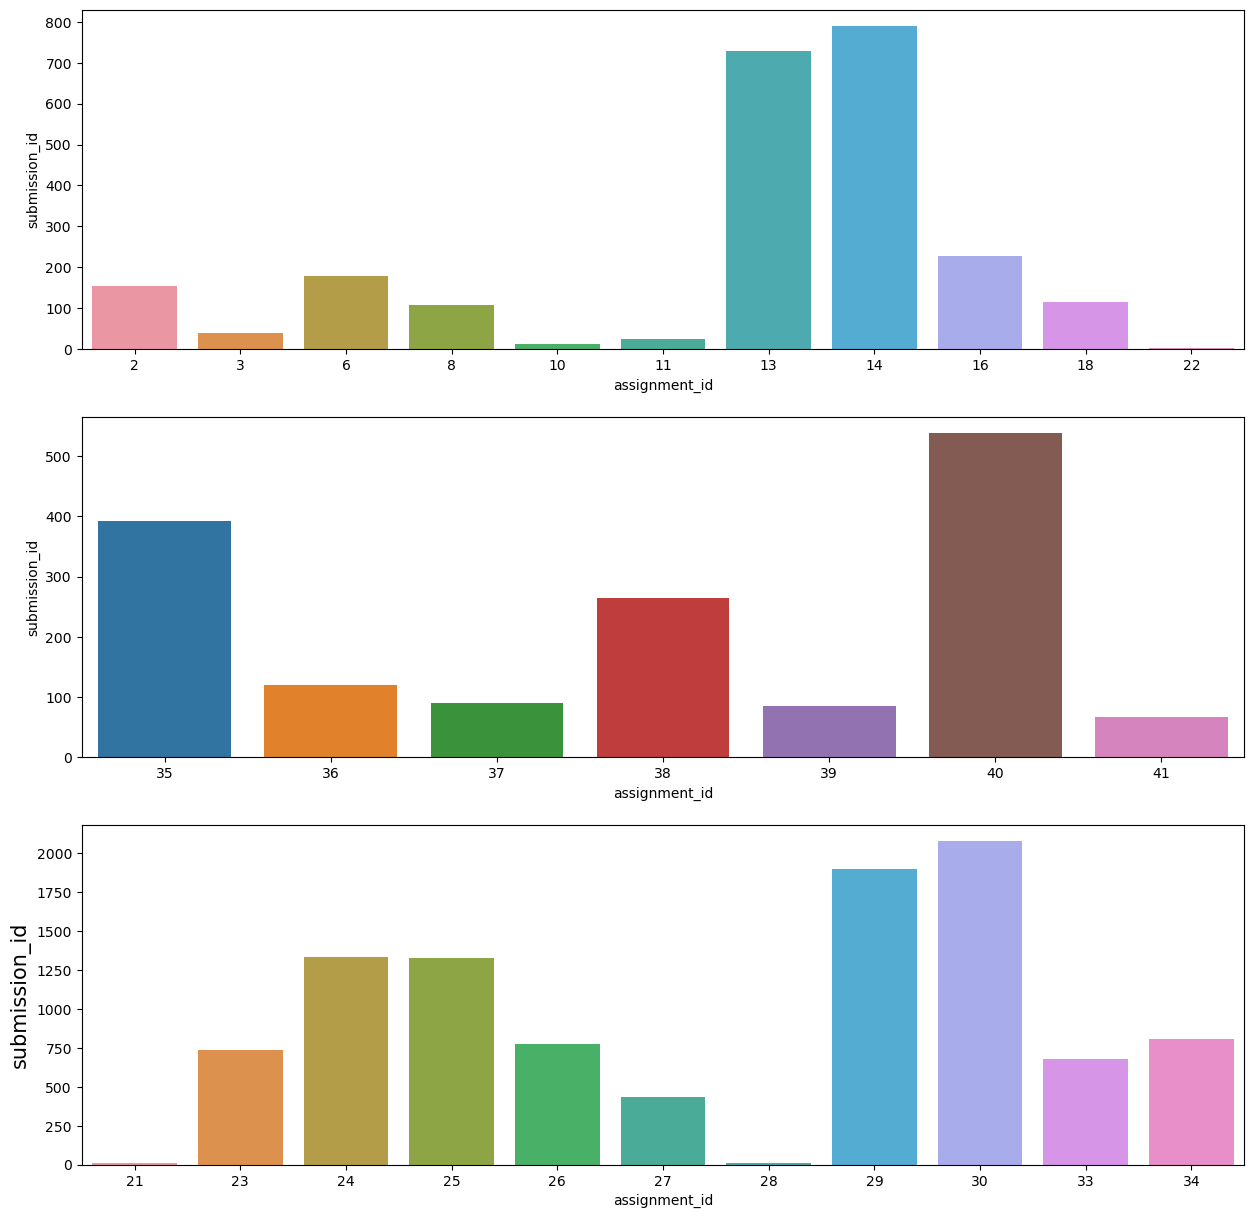

In [128]:
fig, ax = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "DSAA-2021"], ax = ax[0])

plt.ylabel('pH(0(very acidic) to 14(very basic))', fontsize=15)

sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "DSAA-2022"], ax = ax[1])
sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "PY-2022S"], ax = ax[2])

for i in range(3):
    ax[i].set_ylabel('Number of Submissions', fontsize=15)
# plt.show()

In [182]:
submissions_data

,submission_id,assignment_id,student_id,total_score
0,2,2,1,20.0
1,17,2,22,50.0
2,18,2,22,50.0
3,23,2,13,0.0
4,24,2,13,0.0
...,...,...,...,...
21052,21363,41,212,NaN
21053,21364,41,193,NaN
21054,21365,41,195,0.0
21055,21366,41,195,0.0


In [187]:
#4번 각 코스별, 숙제별, 학생별로 처음 만점이 될 때까지의 제출 횟수를 출력하시오 
#단 만점이 아닌 경우에는 출력하지 않습니다.
submission_df = submissions_data[["submission_id", "submit_date", "assignment_id", "student_id", "total_score"]]
# courses_assignment = courses_assignment.drop(['started_date','ended_date'] , axis=1)
total_score_df = pd.merge(courses_assignment, submission_df, on = 'assignment_id', how='left')
total_score_df = total_score_df[total_score_df["total_score"] == 100]

#total_score_df = total_score_df.drop(["submission_id"], axis=1)

In [188]:
total_score_df

,course_id,assignment_id,started_date,ended_date,submission_id,submit_date,student_id,total_score
25,DSAA-2021,2,2021-09-19,2021-09-25,48,2021-09-18 22:01:06,31,100.0
35,DSAA-2021,2,2021-09-19,2021-09-25,58,2021-09-18 23:09:00,30,100.0
37,DSAA-2021,2,2021-09-19,2021-09-25,60,2021-09-18 23:09:40,22,100.0
40,DSAA-2021,2,2021-09-19,2021-09-25,63,2021-09-18 23:13:29,22,100.0
42,DSAA-2021,2,2021-09-19,2021-09-25,65,2021-09-18 23:21:16,13,100.0
...,...,...,...,...,...,...,...,...
20996,PY-2022S,34,2022-05-29,2022-06-13,17922,2022-06-18 22:36:17,69,100.0
21044,PY-2022S,34,2022-05-29,2022-06-13,17970,2022-06-18 23:15:00,136,100.0
21049,PY-2022S,34,2022-05-29,2022-06-13,17975,2022-06-18 23:24:28,136,100.0
21050,PY-2022S,34,2022-05-29,2022-06-13,17976,2022-06-18 23:30:35,66,100.0


In [205]:
# cumcount()... 권용근이는 알고있음...
my_list = []
for ids_, tmpdf in total_score_df.groupby(["course_id", "assignment_id", "student_id"]):
    tmpdf.sort_values("submit_date", inplace=True)
    tmpdf["order_by_date"] = list(range(1, tmpdf.shape[0] + 1))
    my_list.append(tmpdf)
    
test = pd.concat(my_list)

In [208]:
test = test[test["order_by_date"] == 1]

In [209]:
test

,course_id,assignment_id,started_date,ended_date,submission_id,submit_date,student_id,total_score,order_by_date
120,DSAA-2021,2,2021-09-19,2021-09-25,206,2021-09-22 19:32:11,12,100.0,1
42,DSAA-2021,2,2021-09-19,2021-09-25,65,2021-09-18 23:21:16,13,100.0,1
72,DSAA-2021,2,2021-09-19,2021-09-25,102,2021-09-20 02:53:28,15,100.0,1
59,DSAA-2021,2,2021-09-19,2021-09-25,88,2021-09-20 01:20:22,16,100.0,1
87,DSAA-2021,2,2021-09-19,2021-09-25,158,2021-09-20 18:49:30,18,100.0,1
...,...,...,...,...,...,...,...,...,...
20226,PY-2022S,34,2022-05-29,2022-06-13,17152,2022-06-11 15:37:17,148,100.0,1
20139,PY-2022S,34,2022-05-29,2022-06-13,17064,2022-06-10 22:38:49,152,100.0,1
20573,PY-2022S,34,2022-05-29,2022-06-13,17499,2022-06-15 19:55:50,155,100.0,1
19955,PY-2022S,34,2022-05-29,2022-06-13,16880,2022-06-09 23:22:23,162,100.0,1


In [ ]:
# total_score_df 중복처리 ?
# total_score_df = total_score_df.drop(["submission_id"], axis=1)
# total_score_df = total_score_df.drop_duplicates()

#100점 여러개인것 고려/ 중복 처리는 ?

In [13]:
# score_count = submission_df.groupby(["assignment_id","student_id"]).agg({
#     "total_score": "count"
# })

# pd.merge(total_score_df, score_count, on= "student_id",how= 'right')

,course_id,assignment_id,started_date,ended_date,student_id,total_score_x,total_score_y
0,NaN,NaN,NaT,NaT,1.0,NaN,1
1,NaN,NaN,NaT,NaT,2.0,NaN,1
2,DSAA-2021,2.0,2021-09-19,2021-09-25 00:00:00,11.0,100.0,0
3,DSAA-2021,6.0,2021-09-23,2021-09-24 00:00:00,11.0,100.0,0
4,DSAA-2021,8.0,2021-09-23,2021-09-24 00:00:00,11.0,100.0,0
...,...,...,...,...,...,...,...
5754,DSAA-2022,36.0,2022-09-16,2022-09-18 00:00:00,210.0,100.0,2
5755,DSAA-2022,38.0,2022-09-19,2022-09-23 00:00:00,210.0,100.0,2
5756,DSAA-2022,39.0,2022-10-05,2022-10-06 00:00:00,210.0,100.0,2
5757,DSAA-2022,40.0,2022-10-12,2022-10-25 23:59:59,210.0,100.0,2


In [47]:
# 8번 각 코스별, 각 숙제별로 학생들이 처음 제출한 시간과 마지막으로 제출한 시간을 출력하시오
# gantt chart / course 별로 
submitdate_df.groupby(['course_id','assignment_id']).agg({
                            'submit_date': [min,max]
                        })

submit_date                    
                                        min                 max
course_id assignment_id                                        
DSAA-2021 2             2021-09-20 00:53:24 2021-09-24 23:51:11
          3             2021-09-18 14:30:01 2021-10-01 00:32:52
          6             2021-09-23 10:35:09 2021-09-23 23:33:24
          8             2021-09-23 16:06:08 2021-09-23 23:58:16
          10            2021-09-26 21:35:40 2021-10-02 15:03:38
          11            2021-09-27 03:01:48 2021-10-04 20:04:10
          13            2021-09-28 10:22:41 2021-10-04 23:59:54
          14            2021-10-07 10:06:31 2021-10-13 23:58:51
          16            2021-10-31 19:17:00 2021-11-03 23:56:07
          18            2021-11-16 10:15:11 2021-11-17 23:52:59
          22            2022-04-08 20:01:30 2022-04-08 20:35:30
DSAA-2022 35            2022-09-16 09:51:19 2022-09-17 19:59:15
          36            2022-09-16 09:50:32 2022-09-17 02:40:58
          37            2022-09-16 13:04:01 2022-09-17 23:35:14
          38            2022-09-20 16:57:08 2022-09-22 23:56:29
          39            2022-10-05 15:19:33 2022-10-05 23:43:59
          40            2022-10-12 13:48:40 2022-10-25 23:57:49
          41            2022-12-06 19:31:49 2022-12-10 23:46:36
PY-2022S  21            2022-04-08 20:01:05 2022-04-08 20:37:34
          23            2022-04-06 11:11:21 2022-04-08 23:46:25
          24            2022-04-06 09:55:13 2022-04-15 23:58:27
          25            2022-04-06 09:54:52 2022-04-15 23:58:40
          26            2022-04-13 00:45:50 2022-04-29 21:39:40
          27            2022-04-08 19:56:55 2022-04-22 23:58:04
          28            2022-04-08 20:01:15 2022-04-13 08:21:20
          29            2022-04-08 20:44:27 2022-04-22 23:58:50
          30            2022-04-27 11:31:46 2022-05-06 21:10:25
          33            2022-05-04 11:03:22 2022-05-13 23:15:23
          34            2022-05-29 17:27:49 2022-06-12 23:18:12